In [19]:
import os
import numpy as np
import h5py
from scipy import stats
import scipy.io
import mne

mne.set_log_level('error')

from random import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchsummary import summary

import optuna


from utils.load import Load
from config.default import cfg

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data_root = 'C:/Data/UHD_EEG/'

subjects = ['S1', 'S2', 'S3', 'S4', 'S5']
dominant_hand = ['left','right','right','right','right']
mapping = {0: "No instruction", 1: "Rest", 2: "thumb", 3: "index", 4: "middle", 5: "ring", 6: "little"}


def get_montage(hemishpere):
    mat = scipy.io.loadmat(os.path.join(data_root, 'montage', f'montage_256_{hemishpere}_hemisphere.mat'))
    return mat['pos_256']

left_handed_montage = get_montage('right')
right_handed_montage = get_montage('left')


def load_run(subject_id, run, describe=True):
    subject = subjects[subject_id]
    mat = scipy.io.loadmat(os.path.join(data_root, 'rawdata', subject, run))
    data = mat['y'][1:]  # remove timestamp
    ch_names = [f'c{i}' for i in range(1, 257)] + ['STIM']
    info = mne.create_info(ch_names=ch_names, sfreq=mat['SR\x00'][0][0])

    raw = mne.io.RawArray(data, info)
    ch_types = {ch: 'eeg' if ch != 'STIM' else 'stim' for ch in ch_names}
    raw.set_channel_types(ch_types)

    events = mne.find_events(raw, stim_channel='STIM')
    annot_from_events = mne.annotations_from_events(events, event_desc=mapping, sfreq=raw.info['sfreq'])
    raw.set_annotations(annot_from_events)
    raw.drop_channels(['STIM'])

    montage_positions = left_handed_montage if dominant_hand[subject_id] == 'left' else right_handed_montage
    montage = mne.channels.make_dig_montage(ch_pos=dict(zip(ch_names, montage_positions)), coord_frame='head')
    raw.set_montage(montage)

    if describe:
        raw.describe()
    return raw
demo = load_run(0, 'S1_run1.mat', describe=False)

In [3]:
torch.manual_seed(42)
np.random.seed(42)


In [4]:
subject_id = 0

In [5]:
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_name)
print(device)

cuda


In [6]:
# Load the data  from the HDF5 file
target_dir = 'features'
tag = 'reproduced_with_bad'
file_path = os.path.join(target_dir, tag+'_'+cfg['subjects'][subject_id] + '.h5')


data = {}
with h5py.File(file_path, 'r') as h5file:
    for key in h5file.keys():
        data[key] = np.array(h5file[key])

# Time first [Time, Channels, Features]
for key, value in data.items():
    data[key] = np.transpose(value, (0, 2, 1, 3))

# Print the loaded data dictionary
for key, value in data.items():
    print(key, value.shape)

index (50, 26, 158, 2)
little (50, 26, 158, 2)
middle (50, 26, 158, 2)
ring (50, 26, 158, 2)
thumb (50, 26, 158, 2)


In [7]:
X = np.concatenate(list(data.values()), axis=0)
y = np.concatenate([np.ones(data[finger].shape[0]) * i for i, finger in enumerate(data)], axis=0)


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

        self.X = torch.from_numpy(X).float().to(device)
        self.y = torch.from_numpy(y).long().to(device)


    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        features = self.X[idx]
        label = self.y[idx]
        
        return features, label

train_dataset = CustomDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)

test_dataset = CustomDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=True)

In [8]:
for features, label in train_dataloader:
    print(features.shape)
    print(label)
    break

torch.Size([10, 26, 158, 2])
tensor([2, 3, 1, 0, 0, 2, 4, 0, 3, 2], device='cuda:0')


In [9]:
def accuracy(dataloader):
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for features,  labels in dataloader:

            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    accuracy = correct_predictions / total_predictions

    return accuracy * 100

In [13]:
class SingleLayerMLP(nn.Module):
    def __init__(self, time_stamps, channels, rnn_hidden_size,  output_size, activation):
        super(SingleLayerMLP, self).__init__()
        self.activation = activation
        self.channels = channels
        self.fc1 = nn.Linear(2, 1)
        self.fc2 = nn.Linear(channels*time_stamps, 40)
      
        self.fc3 = nn.Linear(40, output_size)
    
        self.dropout = nn.Dropout(0.1)
        
        
    def forward(self, x):

       
        # Merge Mu and Beta band power features
      

        # A version
        #x = x.view(-1, 2)
        x = x.reshape(-1,2)
        x = self.fc1(x)         # Apply the linear layer
        x = x.view(-1, time_stamps, channels)         # Reshape the tensor back to its original shape: (26, 158)
        
        
        x = x.reshape(-1, channels*time_stamps)
        x = self.fc2(x)
        
        
       
       
        
        x = self.activation(x)
        x = self.dropout(x)
       
        #x  = x.reshape(10, 26*64)
       
      
    
        x = self.fc3(x)
        #x = nn.Softmax(dim=1)(x)
        return x



In [14]:
num_epochs = 100
learning_rate = 1e-3
rnn_hidden_size = 8



time_stamps = X.shape[1]
channels = X.shape[2]
model = SingleLayerMLP(time_stamps, channels, rnn_hidden_size, 5, nn.ReLU())
#summary(model, input_size=(X[0].shape));
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
def train(num_epochs, verbose = False):
    # single train
    model.train()
    for epoch in range(num_epochs):

        epoch_loss = 0.0
        for X, y in train_dataloader:
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        if  verbose and (epoch+1) % 10 == 0:
            train_accuracy = accuracy(train_dataloader)
            test_accuracy = accuracy(test_dataloader)
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss}, Train accuracy: {train_accuracy:.2f}%, Test accuracy: {test_accuracy:.2f}%")

    return accuracy(test_dataloader)

train(num_epochs, verbose=True)

Epoch 10/100, Loss: 24.521720111370087, Train accuracy: 62.00%, Test accuracy: 28.00%
Epoch 20/100, Loss: 6.791089653968811, Train accuracy: 92.50%, Test accuracy: 28.00%
Epoch 30/100, Loss: 3.0655480585992336, Train accuracy: 97.50%, Test accuracy: 26.00%
Epoch 40/100, Loss: 1.781559087568894, Train accuracy: 99.50%, Test accuracy: 30.00%
Epoch 50/100, Loss: 1.261649412335828, Train accuracy: 99.00%, Test accuracy: 28.00%
Epoch 60/100, Loss: 0.9151467098854482, Train accuracy: 98.50%, Test accuracy: 28.00%
Epoch 70/100, Loss: 2.8901807772926986, Train accuracy: 99.00%, Test accuracy: 26.00%
Epoch 80/100, Loss: 0.6260551799787208, Train accuracy: 100.00%, Test accuracy: 28.00%
Epoch 90/100, Loss: 0.6793843598570675, Train accuracy: 99.50%, Test accuracy: 32.00%
Epoch 100/100, Loss: 0.6684687180095352, Train accuracy: 99.00%, Test accuracy: 32.00%


38.0

index


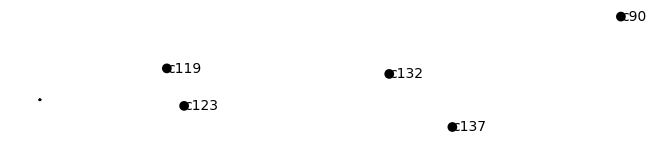

little


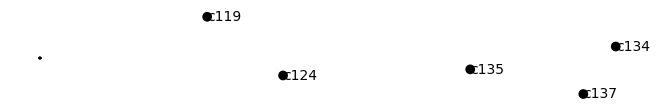

middle


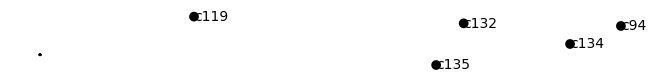

ring


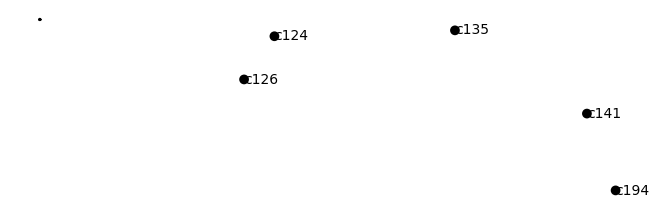

thumb


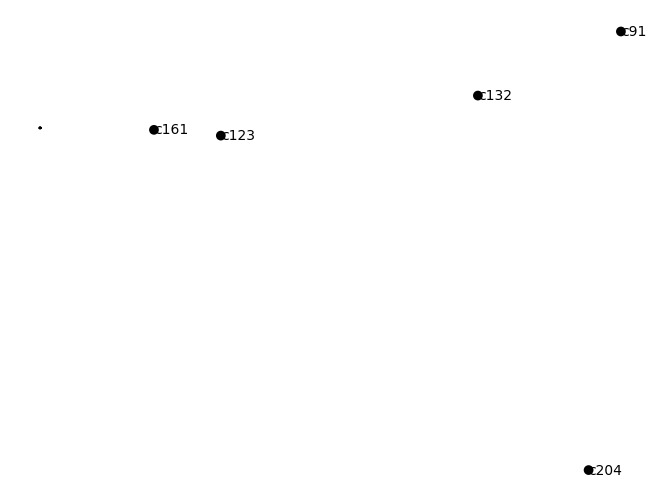

In [21]:
top = 5

model.eval()
# Print the loaded data dictionary
for key, features in data.items(): # BOTH Train and Test

    print(key)
    summ = np.empty((50, 158))
    for i, f in enumerate(features):

        X = torch.from_numpy(f).float().to(device)
        X = X.unsqueeze(0)

        X.requires_grad_(True)

    
        outputs = model(X)

        max_scores = outputs.max(dim=1)[0]
    
        max_scores.backward(retain_graph=True)

        saliency = X.grad
        
        saliency = saliency.squeeze(0)              # REMOVE BATCH DIMENSION
        saliency = saliency.abs()                   # ABSOLUTE VALUE
        saliency = torch.max(saliency, dim=-1)[0]   # MAX OVER FREQUNCY BANDS
        saliency = torch.mean(saliency, dim=0)      # MEAN OVER TIME
        saliency = saliency.cpu().detach().numpy()  # CONVERT TO NUMPY ARRAY
        summ[i] = saliency
    average = np.mean(summ, axis=0)
    bests = np.argpartition(average, -top)[-top:]
    best_channels = [cfg['kept_channel_names']['S1'][i] for i in bests]
    #print(best_channels)
    saliency =  demo.copy().pick_channels(best_channels)
    saliency.plot_sensors(show_names=True);
    plt.show()



